<a href="https://colab.research.google.com/github/Pimmiiiu/DW/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')
df.head()

,age,parity,hiv,menopaus,disease,surgery,conization,OPDsize,appearance,stage,pchemo,Wardsize,finalhisto,nodeyiel,RHlvsi,depth,size,utmet,vgmargin,vgmet,pelvicme,pmmet,adnmet
hn,,,,,,,,,,,,,,,,,,,,,,,
2631840,52,3,0.0,0.0,1,1,0.0,5.0,4.0,5.0,0.0,5.0,3.0,21.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2633481,32,2,0.0,0.0,0,1,0.0,5.0,1.0,5.0,0.0,5.0,1.0,11.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,2.0
2634477,52,2,0.0,0.0,0,0,0.0,5.0,NaN,5.0,0.0,5.0,4.0,35.0,6.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2633633,38,2,0.0,0.0,0,0,0.0,2.0,1.0,4.0,0.0,3.0,3.0,20.0,16.0,3.0,3.8,0.0,0.0,0.0,0.0,0.0,2.0
2630496,55,3,0.0,1.0,0,0,1.0,0.0,5.0,4.0,0.0,0.0,1.0,17.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# 2. Data Pre-Processing

Remove Missing Value and Unnecessary Column

In [0]:
df.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
appearance    101
stage          24
pchemo          1
Wardsize      145
finalhisto     10
nodeyiel       12
RHlvsi        366
depth         489
size          114
utmet          98
vgmargin       96
vgmet          97
pelvicme        1
pmmet          94
adnmet          7
dtype: int64

In [0]:
df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis = 1)

Remove Row with Missing Value

In [0]:
df_clean = df_clean_column.dropna(axis = 0)

Check Total Final Data

In [0]:
df_clean.shape

(1555, 15)

Define Class

In [0]:
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values

Check number of sample for each Class

In [0]:
allclass = np.unique(y)
allclassnumber = [sum(y==eachclass) for eachclass in allclass]
allclassnumber

[1278, 277]

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_res, y_res = sm.fit_resample(X, y)

allclass = np.unique(y_res)
allclassnumber = [sum(y_res==eachclass) for eachclass in allclass]
allclassnumber

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


[1278, 1278]

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=1)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_norm =  scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

# 3. Choose Model

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {'C': [1, 2, 4, 8, 16]}
clf = GridSearchCV(LogisticRegression(random_state=0, solver='liblinear'),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 4}
10CV accuracy : 78.47094801223241


In [0]:
y_predict = clf.predict(X_test_norm)
print("Test accuracy : "+str(sum(y_test == y_predict)/len(y_test)*100))

Test accuracy : 73.6328125


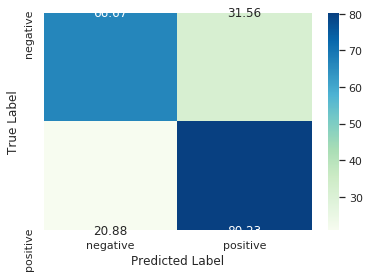

In [0]:
#!pip install matplotlib==3.1.0
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C,annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [0]:
#!pip install tensorflow==2.0.0-beta1
import tensorflow as tf

In [0]:
tf.reset_default_graph() # Clear Model
np.random.seed(1) # Fix Randomness
tf.random.set_random_seed(1) # Fix Randomness
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(24, activation='relu', input_shape=(14,)),
  tf.keras.layers.Dense(12, activation='relu'),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(2, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 755
Trainable params: 755
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
train_acc = list()
val_acc = list()
for i in range(0,500):
  history = model.fit(X_train_norm, y_train, epochs= 1, batch_size = 200, validation_data= (X_val_norm, y_val))
  tmp_avg = np.mean(history.history['acc'])
  tmp_avg_val = np.mean(history.history['val_acc'])
  train_acc.append(tmp_avg)
  val_acc.append(tmp_avg_val)

Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 82us/sample - loss: 0.6922 - acc: 0.5162 - val_loss: 0.6816 - val_acc: 0.5623
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 14us/sample - loss: 0.6782 - acc: 0.5761 - val_loss: 0.6720 - val_acc: 0.5966
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 12us/sample - loss: 0.6697 - acc: 0.6104 - val_loss: 0.6655 - val_acc: 0.6406
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 15us/sample - loss: 0.6627 - acc: 0.6306 - val_loss: 0.6595 - val_acc: 0.6430
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 13us/sample - loss: 0.6562 - acc: 0.6410 - val_loss: 0.6544 - val_acc: 0.6553
Train on 1635 samples, validate on 409 samples
1635/1635 [==============================] - 0s 13us/sample - loss: 0.6501 - acc: 0.6575

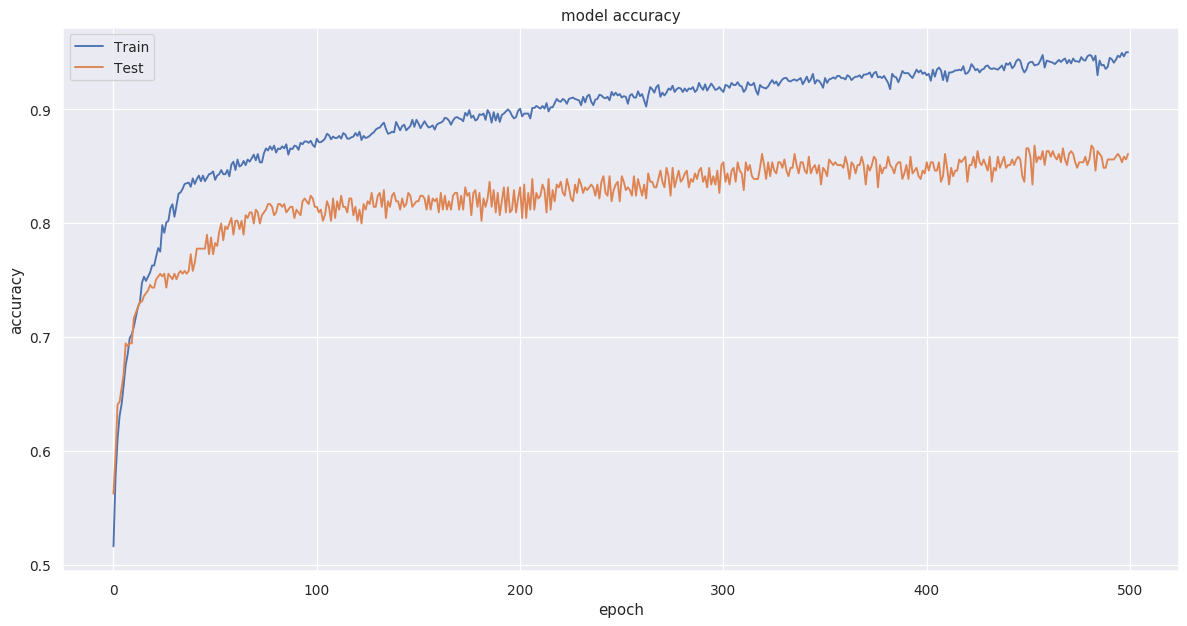

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(num=None, figsize=(16, 8), dpi=90, facecolor='w', edgecolor='k')
plt.plot()
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
y_predict = np.round(model.predict(X_test_norm))
y_predict = [i[0] for i in y_predict.tolist()]
sum(y_predict == y_test)/len(y_test)

0.8359375

# SVM

In [0]:
import numpy as np
from sklearn import svm
clf = svm.SVC(gamma='scale')
clf.fit(X_train_norm,y_train)
y_predict = clf.predict(X_val_norm)
sum(y_predict == y_val) / len(y_val)

0.8141809290953546

In [0]:
from sklearn.model_selection import cross_val_score
accuracy = cross_val_score(clf,X_train_norm,y_train,cv=10)
accuracy.mean()

0.8446643224100953

# XGBoost

In [188]:
from xgboost import XGBClassifier
clf = XGBClassifier(gamma=1,max_depth=8)
accuracy = cross_val_score(clf,X_train_norm,y_train,cv=10)
accuracy.mean()

0.8898873685396703

In [189]:
clf.fit(X_train_norm,y_train)
y_predict = clf.predict(X_val_norm)
sum(y_predict == y_val) / len(y_val)

0.882640586797066

In [190]:
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/Blind.csv')
df = df.set_index('hn')
df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis = 1)
df_clean = df_clean_column.dropna(axis = 0)
y_blind = df_clean['pmmet'].values
X_blind = df_clean.drop(['pmmet'],axis = 1).values
X_blind_norm = scaler.transform(X_blind)
# Normal
y_predict = clf.predict(X_blind_norm )
print("Test accuracy : "+str(sum(y_blind  == y_predict)/len(y_blind)*100))

Test accuracy : 82.01438848920863


In [180]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [10,50,100,200],
          'max_depth':[2,4,8],
          'gamma':[0.03125,0.0625,0.125,0.25,0.5,1,2,4,8,16,32],
          'learning_rate':[0.001,0.01,0.1],
          'minchildweight':[1,2,4,8,16,32]}
clf = GridSearchCV(XGBClassifier(random_state=0, solver='liblinear'),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-180-682705a96628>", line 10, in <module>
    clf.fit(X_train_norm, y_train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py", line 688, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py", line 1149, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py", line 667, in evaluate_candidates
    cv.split(X, y, groups)))
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 1006, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 834, in dispatch_one_batch
    self._dispat

KeyboardInterrupt: ignored

In [0]:
y_predict = clf.predict(X_test_norm)
print("Test accuracy : "+str(sum(y_test == y_predict)/len(y_test)*100))

Test accuracy : 87.6953125
